In [20]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print("Libraries Imported!")

Libraries Imported!


In [21]:
import os
import pandas as pd
import numpy as np

# --- Configuration ---
# Corrected path to the 'Filtered_Data' folder
DATA_PATH = 'Dataset/Filtered_Data' 
NUM_SUBJECTS = 20
SAMPLES_PER_EPOCH = 400  # 2 seconds of data (200 Hz * 2s)
NUM_CHANNELS = 4

# --- Data Loading and Epoching ---
all_epochs = []
all_labels = []

print("Starting data loading and epoching...")

# Loop through each subject (s01 to s20)
for subject_id in range(1, NUM_SUBJECTS + 1):
    # We'll use resting-state eyes-closed data (ex01) for this example
    # You can modify this to include more experiments
    for session_id in range(1, 4):
        # Construct the file path
        file_name = f's{subject_id:02d}_ex01_s{session_id:02d}.csv'
        file_path = os.path.join(DATA_PATH, file_name)

        if os.path.exists(file_path):
            # Load the data using pandas
            df = pd.read_csv(file_path)
            # Get the EEG data (last 4 columns) as a NumPy array
            eeg_data = df.iloc[:, 1:].values
            
            # Slice the data into epochs
            num_samples = eeg_data.shape[0]
            for i in range(0, num_samples - SAMPLES_PER_EPOCH + 1, SAMPLES_PER_EPOCH):
                epoch = eeg_data[i:i+SAMPLES_PER_EPOCH, :]
                all_epochs.append(epoch)
                # Use subject_id-1 as the label (0 to 19)
                all_labels.append(subject_id - 1)
        # else:
            # Optional: print a warning if a file is not found
            # print(f"Warning: File not found at {file_path}")


# Convert lists to NumPy arrays for efficiency
X = np.array(all_epochs)
y = np.array(all_labels)

print(f"Data loading complete.")
print(f"Shape of X (epochs): {X.shape}")
print(f"Shape of y (labels): {y.shape}")

Starting data loading and epoching...
Data loading complete.
Shape of X (epochs): (3575, 400, 4)
Shape of y (labels): (3575,)


In [27]:
# 1. Split the data into training (80%) and testing (20%) sets
# stratify=y ensures that the proportion of each subject is the same in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. One-hot encode the labels
# The model needs labels in the format [0,0,1,0,...] for categorical_crossentropy
y_train_cat = to_categorical(y_train, num_classes=NUM_SUBJECTS)
y_test_cat = to_categorical(y_test, num_classes=NUM_SUBJECTS)


print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train_cat shape: {y_train_cat.shape}")
print(f"y_test_cat shape: {y_test_cat.shape}")

X_train shape: (2860, 400, 4)
X_test shape: (715, 400, 4)
y_train_cat shape: (2860, 20)
y_test_cat shape: (715, 20)


In [23]:
model = Sequential()

# 1. Input Layer (defined by input_shape in the first Conv1D layer)
# Shape: (400 samples, 4 channels)

# 2. First Conv1D Layer
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(SAMPLES_PER_EPOCH, NUM_CHANNELS)))

# 3. MaxPooling1D Layer
model.add(MaxPooling1D(pool_size=2))

# 4. Second Conv1D Layer
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# 5. GlobalAveragePooling1D Layer
model.add(GlobalAveragePooling1D())

# 6. Dense Layer
model.add(Dense(100, activation='relu'))

# 7. Dropout Layer (for regularization)
model.add(Dropout(0.3))

# 8. Output Dense Layer
model.add(Dense(NUM_SUBJECTS, activation='softmax'))

# Print a summary of the model architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 396, 64)           1344      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 198, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 194, 128)          41088     
                                                                 
 global_average_pooling1d_3  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 100)               12900     
                                                                 
 dropout_3 (Dropout)         (None, 100)              

In [28]:
# Compile the model
custom_adam = Adam(learning_rate=0.0005)
model.compile(
    optimizer=custom_adam, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_lr=0.00001)
]


# 4. Start training, passing the 'callbacks_list' to the 'callbacks' argument
print("Starting training...")
# Train the model
# batch_size: number of samples per gradient update
# epochs: number of times to iterate over the entire training dataset
# validation_data: data on which to evaluate the loss and any model metrics at the end of each epoch
history = model.fit(
    X_train, 
    y_train_cat, 
    batch_size=16, 
    epochs=100,  # You can increase this if needed
    validation_data=(X_test, y_test_cat),
    callbacks=callbacks_list
)

Starting training...
Epoch 1/100
173/179 [===========================>..] - ETA: 0s - loss: 0.2394 - accuracy: 0.9216
Epoch 1: val_accuracy improved from -inf to 0.90909, saving model to best_model.h5
179/179 [==============================] - 2s 10ms/step - loss: 0.2407 - accuracy: 0.9210 - val_loss: 0.3547 - val_accuracy: 0.9091 - lr: 5.0000e-04
Epoch 2/100
 20/179 [==>...........................] - ETA: 1s - loss: 0.2261 - accuracy: 0.9312

/home/megh/anaconda3/envs/myenv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


176/179 [============================>.] - ETA: 0s - loss: 0.2135 - accuracy: 0.9272
Epoch 2: val_accuracy did not improve from 0.90909
179/179 [==============================] - 2s 9ms/step - loss: 0.2144 - accuracy: 0.9262 - val_loss: 0.4154 - val_accuracy: 0.8713 - lr: 5.0000e-04
Epoch 3/100
178/179 [============================>.] - ETA: 0s - loss: 0.2300 - accuracy: 0.9224
Epoch 3: val_accuracy improved from 0.90909 to 0.92727, saving model to best_model.h5
179/179 [==============================] - 2s 9ms/step - loss: 0.2297 - accuracy: 0.9224 - val_loss: 0.3047 - val_accuracy: 0.9273 - lr: 5.0000e-04
Epoch 4/100
173/179 [===========================>..] - ETA: 0s - loss: 0.2437 - accuracy: 0.9256
Epoch 4: val_accuracy did not improve from 0.92727
179/179 [==============================] - 2s 9ms/step - loss: 0.2435 - accuracy: 0.9255 - val_loss: 0.3561 - val_accuracy: 0.9119 - lr: 5.0000e-04
Epoch 5/100
174/179 [============================>.] - ETA: 0s - loss: 0.1895 - accuracy:

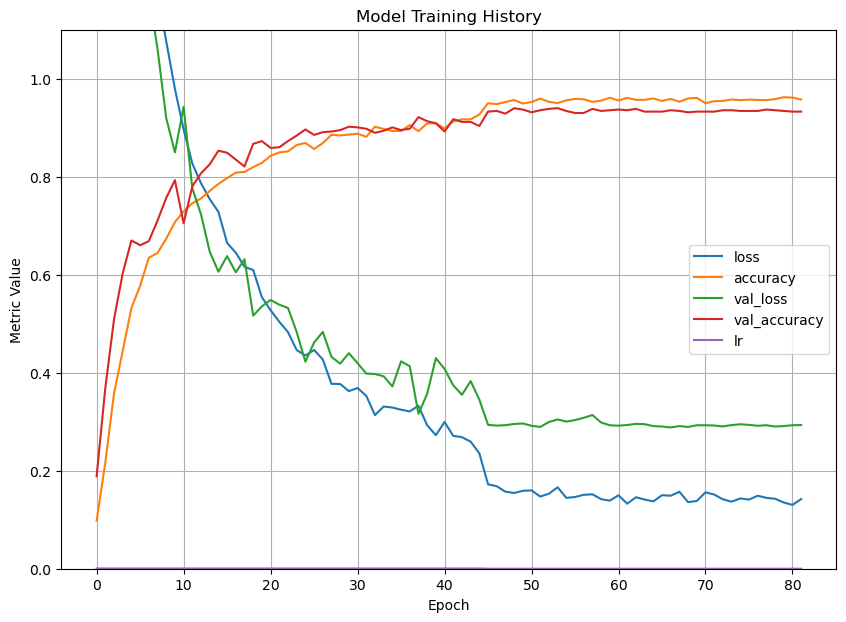

23/23 - 0s - loss: 0.2932 - accuracy: 0.9329 - 168ms/epoch - 7ms/step

Test Accuracy: 93.29%
23/23 [==============================] - 0s 6ms/step


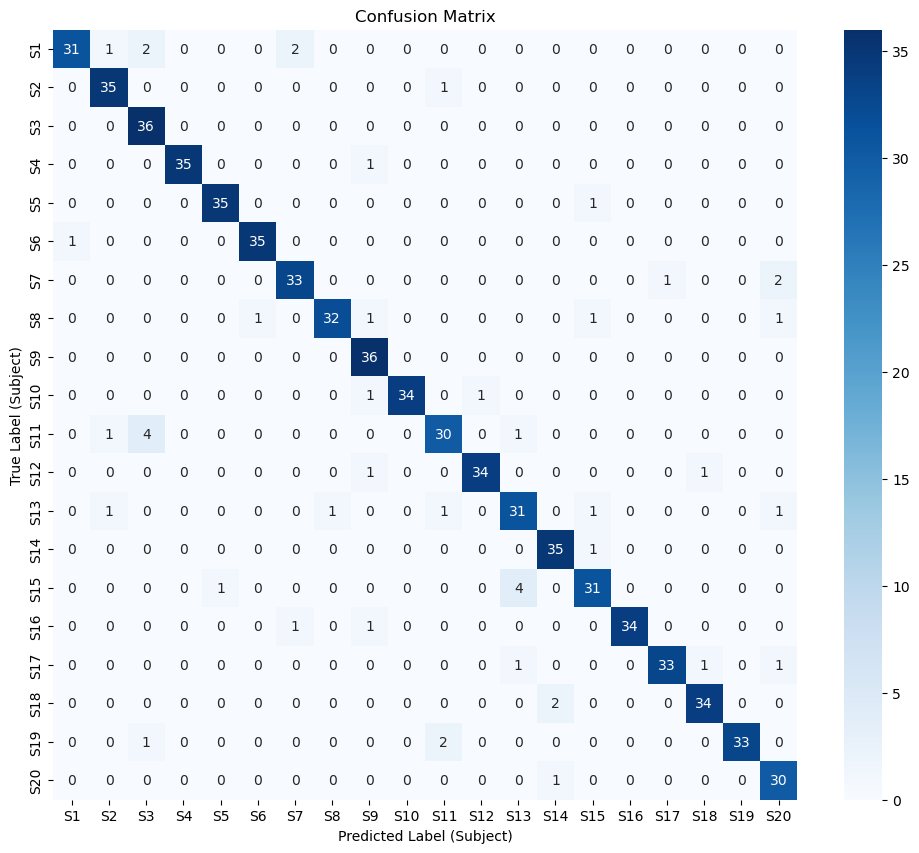

In [26]:
# 1. Plot Training History
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1.1) # set the y-axis range to [0, 1.1]
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.show()

# 2. Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=2)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# 3. Create and Plot a Confusion Matrix
# Get model predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'S{i+1}' for i in range(NUM_SUBJECTS)],
            yticklabels=[f'S{i+1}' for i in range(NUM_SUBJECTS)])
plt.title('Confusion Matrix')
plt.ylabel('True Label (Subject)')
plt.xlabel('Predicted Label (Subject)')
plt.show()